Тестовое задание:

https://grouplens.org/datasets/movielens/latest/ - датасет

Необходимо построить векторные представления(эмбеддинги) пользователей и фильмов используя нейросетевые подходы, чтобы можно было по эмбеддингу пользователя искать похожие эмбеддинги фильмов и рекомендовать ему их.

In [ ]:
#!c1.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch
from tqdm.notebook import tqdm

Посмотрим на данные

In [2]:
#!c1.8
ratings = pd.read_csv('ratings.csv')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
5,1,1590,2.5,1256677236
6,1,1591,1.5,1256677475
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
9,1,2840,3.0,1256677500


Колонкой timestamp пользоваться не будем, удалим ее

In [3]:
#!c1.8
ratings.drop(columns='timestamp', inplace=True)

Посчитаем количество вхождений каждого фильма и пользователя, затем уберем те объекты, которые мало встречаются в данных, это поможет более качественно рекомендовать фильмы и сильно ускорит обучение

In [5]:
#!c1.8
rt = ratings.pivot_table(index = ['movieId'], aggfunc ='size')

ratings['movie_counter'] = ratings['movieId'].apply(lambda x : rt[x])

rt = ratings.pivot_table(index = ['userId'], aggfunc ='size')

ratings['user_counter'] = ratings['userId'].apply(lambda x : rt[x])

In [9]:
#!c1.8
print(np.unique(ratings['movie_counter'].values).mean())
print(np.unique(ratings['user_counter'].values).mean())
print(np.median(np.unique(ratings['user_counter'].values)))

5895.244236128706
1266.1354359925788
1078.5


In [22]:
#!c1.8
new_ratings = ratings[ratings['movie_counter'] > 500]

In [23]:
#!c1.8
new_ratings = new_ratings[new_ratings['user_counter'] > 100]

Изобразим распределение всех оценок

(array([ 295234.,  616827.,  328139., 1365187., 1061361., 3926312.,
        2646230., 5354632., 1741395., 2601882.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

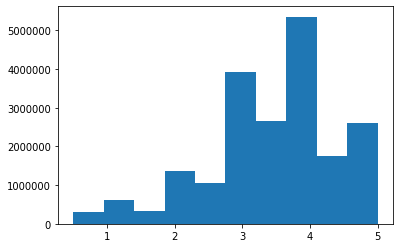

In [24]:
#!c1.8
plt.hist(new_ratings['rating'])

Примерно половина всех оценок имеет рейтинг $\geqslant4$, будем разделять оценки на позитивные и негативные, оценки с рейтингом хотя бы 4 считаем позитивными, иначе негативными

In [25]:
#!c1.8
#ratings.to_csv('ratings_with_counters.csv', index=False)

In [26]:
#!c1.8
new_ratings.shape

(19937199, 5)

Колонки с подсчетами больше не нужны, удалим их 

In [28]:
#!c1.8
new_ratings.drop(columns=['movie_counter'], inplace=True)
new_ratings.drop(columns=['user_counter'], inplace=True)

Переиндексируем юзеров и фильмы для дальнейшей работы

In [29]:
#!c1.8
new_movie_id = dict()
new_user_id = dict()
movie_id = np.unique(new_ratings['movieId'])
user_id = np.unique(new_ratings['userId'])
for index, movie in enumerate(movie_id):
    new_movie_id[movie] = index
for index, user in enumerate(user_id):
    new_user_id[user] = index

In [30]:
#!c1.8
new_ratings['movieId'] = new_ratings['movieId'].apply(lambda x : new_movie_id[x])
new_ratings['userId'] = new_ratings['userId'].apply(lambda x : new_user_id[x])

In [31]:
#!c1.8
new_ratings.reset_index(inplace = True, drop=True)

На валидации мы хотим для каждого пользователя проверить является ли фильм хорошей рекомендацией для него, для этого разделим выборку на train и test используя параметр stratify, чтобы экземпляры каждого пользователя присутствовали и в обучении, и валидации.

In [32]:
#!c1.8
train, test = train_test_split(new_ratings, test_size=0.2, stratify=new_ratings['userId'])

In [33]:
#!c1.8
train.shape, test.shape

((15949759, 3), (3987440, 3))

Разобьем обучающую выборку на позитивные и негативные оценки

In [34]:
#!c1.8
train_pos = train[train['rating']>=4]
train_neg = train[train['rating']<4]
train_pos.shape, train_neg.shape

((7758947, 3), (8190812, 3))

Посмотрим сколько в наших данных уникальных пользователей и фильмов

In [35]:
#!c1.8
num_users = np.unique(new_ratings['userId']).shape[0]
num_movies = np.unique(new_ratings['movieId']).shape[0]
num_users, num_movies

(67448, 5545)

Опишем решение : для обучения эмбеддингов будем использовать Triplet Loss

$L(a,p,n) = max(d(a,p) - d(a,n) + m, 0)$

здесь $d$ - метрика в пространстве эмбеддингов, $a$ - объект пользователь, $p$ - позитивная оценка для юзера, $n$ - негативная оценка, $m$ - margin, как сильно мы хотим разделять(по метрике $d$) позитивные и негативные примеры в пространстве эмбеддингов. В рамках задачи будем считать для каждого юзера негативными те оценки, которые имеют рейтинг меньше 4. В качестве метрики берем $L2$ расстояние

Идея состоит в семплировании триплетов $(a,p,n)$ и обучении с помощью $L(a,p,n)$

Для начала реализуем датасет из триплетов, будет для каждой пары (пользователь, фильм) c позитивной оценкой выбирать случайно фильм с негативной оценкой.

In [36]:
#!c1.8
class Triplets(Dataset):
    def __init__(self, data, num_movies):
        self.num_movies = num_movies
        self.data_pos = data[data['rating'] >= 4]
        self.anchors = self.data_pos['userId'].values
        self.data_pos = self.data_pos['movieId'].values
        self.data_neg = data[data['rating'] < 4]
        self.data_neg = self.data_neg['movieId'].values
        
    def __len__(self):
        return len(self.data_pos)
    
    def __getitem__(self, index):
        anchor = self.anchors[index]
        positive = self.data_pos[index]
        negative_index = np.random.choice(self.data_neg.shape[0])
        negative = self.data_neg[negative_index]

        return anchor, positive, negative

Обернем триплеты в dataloader для обучения

In [45]:
#!c1.8
batch_size = 128

train_dataset = Triplets(train, num_movies)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Сама архитектура крайне проста, имеем две различные головы для построения эмбеддингов юзеров и фильмов. Для юзера и фильма модель будет возвращать расстояние между ними(далее эти расстояния будут интерпретироваться как вероятности). Так как triplet loss старается отделить от $a$ негативные эмбеддинги $n$, а позитивные $p$ приблизить, то чем меньше будет расстояние между объектами, тем лучше данная рекомендация.

In [46]:
#!c1.8
class Embeddings(nn.Module):
    def __init__(self, num_users, num_movies, embed_dim, margin=10):
        super().__init__()
        self.margin = margin
        self.embed_dim = embed_dim
        self.num_users = num_users
        self.num_movies = num_movies
        
        #self.cos = nn.CosineSimilarity()
        
        self.user_head = nn.Sequential(nn.Embedding(self.num_users, self.embed_dim), nn.Flatten())
        self.movie_head = nn.Sequential(nn.Embedding(self.num_movies, self.embed_dim), nn.Flatten())
        
    def forward(self, anchor, positive, negative):
        embed_anchor = self.user_head(anchor)
        embed_positive = self.movie_head(positive)
        embed_negative = self.movie_head(negative)
        
        dist1 = ((embed_anchor - embed_positive)**2).sum(axis=1)
        dist2 = ((embed_anchor - embed_negative)**2).sum(axis=1)
        
        #return (1 - torch.sigmoid(dist1 - dist2)).sum()
        return torch.relu(dist1 - dist2 + self.margin)
    
    def predict(self, user, movie):
        with torch.no_grad():
            embed_user = self.user_head(torch.tensor(user, dtype=torch.int32))
            embed_movie = self.movie_head(torch.tensor(movie, dtype=torch.int32))
            return ((embed_user - embed_movie)**2).sum(axis=1)

В качестве метрики будем использовать средний ROC-AUC по всем пользователям. Выбор метрики объясняется тем, что в рамках данного решения мы для каждого юзера предсказываем вероятность того, что он оценит данную рекомендацию как положительную, при этом чем расстояние в пространстве эмбеддингов меньше, тем рекомендация более вероятна. Формально мы хотим оценить то, как хорошо для конкретного юзера были упорядочены фильмы(в смысле метрики $L2$), ROC-AUC делает именно это.

In [47]:
#!c1.8
def auc_roc(test, model, num_users, num_movies):
    auc_scores = []
    for user in tqdm(range(num_users)):
        user_test = test[test['userId']==user]
        user_test_movies = user_test['movieId'].values
        user = [user] * len(user_test_movies)
        results = model.predict(user, user_test_movies)
        labels = user_test['rating'].apply(lambda x : x >= 4).values
        results /= results.sum()
        if (np.unique(labels).shape[0] > 1):
            auc_scores.append(roc_auc_score(labels, 1 - results)) # здесь 1 - results, потому что чем расстояние больше - тем больше вероятность,
    return np.mean(np.array(auc_scores))                          # а в нашем пространстве чем объекты ближе, тем рекомендация лучше, поэтому
                                                                  # вероятности надо обратить

Создадим модель и оптимизатор

In [48]:
#!c1.8
model = Embeddings(num_users, num_movies, embed_dim=64, margin=80)
optimizer = torch.optim.Adam(model.parameters())

Реализуем функции для обучения

In [49]:
#!c1.8
def train_model(model, optimizer, loader):
    model.train()
    losses_tr = []
    
    for (anchors, positives, negatives) in tqdm(loader):
        optimizer.zero_grad()
        loss = model(anchors, positives, negatives)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
        
    return model, optimizer, np.mean(losses_tr)

In [50]:
#!c1.8
from IPython.display import clear_output
from tqdm.notebook import trange

In [51]:
#!c1.8
def learning_loop(model, optimizer, train_loader, epochs=40, draw_every=1, separate_show=False):
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train_model(model, optimizer, train_loader)
        losses['train'].append(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()
            
            plt.show()

    return model, optimizer, losses

Обучим модель:

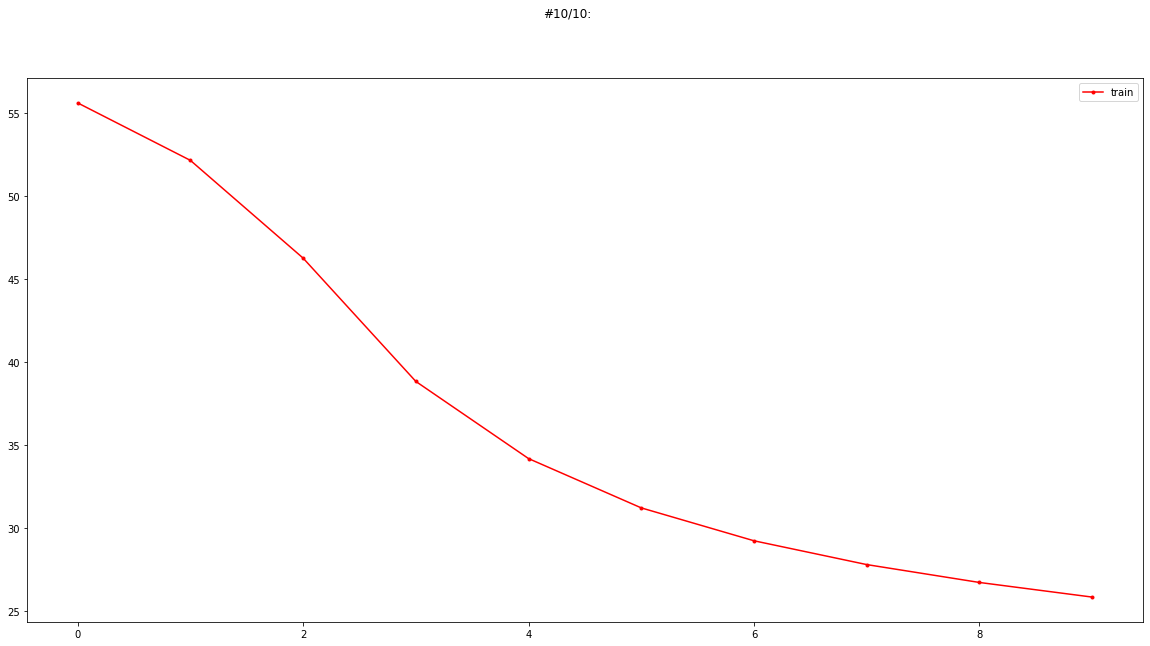

(Embeddings(
   (user_head): Sequential(
     (0): Embedding(67448, 64)
     (1): Flatten(start_dim=1, end_dim=-1)
   )
   (movie_head): Sequential(
     (0): Embedding(5545, 64)
     (1): Flatten(start_dim=1, end_dim=-1)
   )
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ),
 {'train': [55.62204623447723,
   52.160433048176735,
   46.272226261027086,
   38.844610094758615,
   34.19719822432688,
   31.2277913397131,
   29.246611526590325,
   27.813031633304924,
   26.736187483769303,
   25.855586468718165],
  'val': []})

In [52]:
#!c1.8
learning_loop(model, optimizer, train_loader, epochs=10)

Посмотрим на качество модели на тестовых данных:

In [54]:
#!c1.8
print(auc_roc(test, model, num_users, num_movies))


0.7234643251512703


Дальнейшие улучшения :
1) В своей статье https://arxiv.org/pdf/1503.03832.pdf авторы обращают особое внимание на подбор триплетов для обучения, в приведенном решении триплеты выбирались из позитивных и негативных случайно, однако, если на каждом шаге подбирать для юзера hard-триплеты, то это сильно улучшит качество модели. 2) Вместо просто слоев nn.Embedding можно в архитектуру добавить полносвязные слои. 3) Попробовать получше подобрать параметр $m$ в лоссе